# Fit the Bead Size $\sigma$ to Experimental Data from the Prabhu Group

Because our paper ultimately makes a comparison between its predictions of LCST phase separation and the experimental measurements reported by the Prabhu group, we decided to fit our one fitting parameter, the bead size $\sigma$, to minimize the squared residual error between our predictions and the Prabhu data.

In [1]:
%load_ext autoreload
%autoreload 2

# Python libraries
import numpy as np
import math
import matplotlib.pyplot as plt
# 3rd party libraries
import pandas as pd
# Custom libraries
import salt
import pe
import plot

# parameters for range of bead sizes to consider [A]
sigma_min = 4.0
sigma_max = 4.6
dsigma = 0.01

# filepath to experimental data file
exp_data_filepath = '../REFERENCES/CCLS/Data/prabhu_experimental_data_raw.csv'
# filepath to predicted results for charge fraction f = 1 and degree of polymerization N = 1000
pred_filepath = 'salt/vary_params/'
# name of data file
ext = 'output.dat'
N = 1000
f = 1

# DERIVED PARAMETERS
# determines naming structure of files with given parameters
naming_structure = 'NA({0:d})NB({0:d})*f({1:.3f})'.format(N, f)
# range of bead sizes (sigma) to consider [A]
n_sigma = int(np.round((sigma_max - sigma_min) / dsigma)) + 1
sigma_range = np.linspace(sigma_min, sigma_max, n_sigma)

# CONVERSIONS
A_2_m = 1E-10

# FUNCTIONS


## Load Measured Compositions

In [2]:
# loads experimental data
df_exp = pd.read_csv(exp_data_filepath)

df_exp.head()

,rho_p [M],rho_s [M],T [C],rho_p^sup [M],sigma_p^sup [M],rho_p^co [M],sigma_p^co [M],first author
0,0.3,1.75,5,0.0172,0.0004,1.04,0.04,ali
1,0.3,1.75,10,0.0168,0.0004,1.16,0.04,ali
2,0.3,1.75,15,0.0140,0.0004,1.18,0.04,ali
3,0.3,1.75,20,0.0136,0.0004,1.18,0.04,ali
4,0.3,1.75,25,0.0130,0.0004,1.30,0.04,ali


### Correct for Errors in Overall Salt and Polymer Concentrations in Data from Ali et al. (2019)

Dr. Yuanchi Ma informed me that, in the work by Ali et al. (2019), 1 mol of polymer + 1 L of water was reported as a "1 mol/L" solution, whereas he found that 1 mol of polymer + 920 mL of water resulted in a true 1 mol/L solution (1 mol of solute per liter of solution). This indicates that adding 1 mol of polymer to an aqueous solution adds roughly 80 mL of volume.

To determine the effect of adding salt on the volume of the solution, we use sea water (NaCl + H2O) as a reference.
It is known that sea water has a concentration of NaCl of 0.6 M. The molar mass of NaCl is $M_{NaCl} = M_{Na} + M_{Cl} = 23~\text{g} + 35.5~\text{g} = 58.5~\text{g/mol}$. Consequently, 0.6 mol of NaCl is equivalent to $0.6~\text{mol} \times 58.5~\text{g/mol} \approx 35~\text{g}$.

The density of sea water is about 1.02 g/mL, so 1 L of sea water has a mass of 1020 g. Of these, we found that 35 g come from the NaCl, so the remaining 985 g come from the water. Water has a density of 1 g/mL, so the water occupies 985 mL (assuming no free volume of mixing). The remaining 15 mL must therefore come from the presence of salt. This makes sense because the density of NaCl is 2.16 g/mL, and 35 g / 15 mL = 2.3 g/mL, indicating that there is negligible volume of mixing.

The salt used by Ali et al., KBr, has a density of 2.75 g/mL, so we (hopefully reasonably) assume that its density does not change dramatically upon dissolving in water. The molar mass of KBr is $M_{KBr} = M_{K} + M_{Br} = 39.1~\text{g} + 79.9~\text{g} = 119~\text{g/mol}$.

In [3]:
simple_red = 0.9 # bypass complex estimation, simply reduce experimental values by 10%
df_exp = salt.df_conv_ali_conc(df_exp, simple_red=simple_red)
df_exp.head()

C:\Users\andyl\OneDrive - California Institute of Technology\Documents\Research\Wang\complex_coacervate\salt.py:191: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\andyl\OneDrive - California Institute of Technology\Documents\Research\Wang\complex_coacervate\salt.py:192: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\andyl\OneDrive - California Institute of Technology\Documents\Research\Wang\complex_coacervate\salt.py:194: SettingWithCopyWarning:


A value is trying to be set on a copy of a 

,rho_p [M],rho_s [M],T [C],rho_p^sup [M],sigma_p^sup [M],rho_p^co [M],sigma_p^co [M],first author,rho_p (conv) [M],rho_s (conv) [M]
0,0.3,1.75,5,0.0172,0.0004,1.04,0.04,ali,0.27,1.575
1,0.3,1.75,10,0.0168,0.0004,1.16,0.04,ali,0.27,1.575
2,0.3,1.75,15,0.0140,0.0004,1.18,0.04,ali,0.27,1.575
3,0.3,1.75,20,0.0136,0.0004,1.18,0.04,ali,0.27,1.575
4,0.3,1.75,25,0.0130,0.0004,1.30,0.04,ali,0.27,1.575


## Load Predicted Compositions

In [4]:
data_pred = salt.load_data(pred_filepath, naming_structure=naming_structure, ext=ext)

## Compute Residual Squared Error for Range of Bead Sizes

In [7]:
# include error from supernatant even though all models drastically underestimate its polymer composition?
include_sup = True
# corrects values from Ali et al. 2019 by accounting for added volume of solute
conv_vals = True
# fit to a specific author's data? Options are 'ali', 'ma', or list both
fit_to = ['ali', 'ma']



# restricts fit to only requested datasets
fit_condition = None
for i, author in enumerate(fit_to):
    # initializes condition with first option
    if i == 0:
        fit_condition = df_exp['first author'] == author
    # applies element-wise 'or' (parentheses important!) to combine new and old conditions
    else:
        fit_condition = (fit_condition) | (df_exp['first author'] == author)
        
# creates dataframe to use for fit
df_fit = df_exp.loc[fit_condition]

# initializes dictionary to store residuals
res_dict = {}
# collects Bjerrum lengths for which there are predictions
lB_arr = np.asarray([lB for lB in data_pred.keys()])

for sigma in sigma_range:
    
    # gets conversion factor for mol/L (M)
    beads_2_M = pe.get_beads_2_M(sigma)
    
    res = []
    for i in range(len(df_fit)):
        rho_p, rho_s, T_exp, rho_p_sup, rho_p_co, err_sup, err_co = salt.read_df_exp(df_fit, i, 
                                                                     read_sigma=True, conv_vals=conv_vals)
        
        # computes Bjerrum length for the given temperature
        lB = pe.lB_fn(T_exp + 273.15, sigma=sigma*A_2_m)
        # finds the closest Bjerrum length in the numerical dataset
        i_lB = np.argmin( (lB - lB_arr)**2 )
        lB = lB_arr[i_lB]
      
        # computes the concentrations of supernatant and coacervate phases at given overall composition
        # "pc" = "polycation"
        rho_pc_sup_pred, rho_pc_co_pred, _, _, lB_check, _ = salt.fixed_rho_total({lB : data_pred[lB]}, 
                                                                                rho_p, rho_s, beads_2_M)
        # if no prediction available under the given conditions, ignores that data point
        if len(lB_check) == 0:
            continue
        else:
            # approximates polyelectrolyte concentration as 2 x polycation concentration
            rho_p_sup_pred = 2*rho_pc_sup_pred[0]
            rho_p_co_pred = 2*rho_pc_co_pred[0]
            lB_check = lB_check[0]
           
        
        assert lB_check == lB, 'Bjerrum lengths do not match'
        
        # compares prediction with experimental measure to compute residual
        res += [include_sup*np.abs( (rho_p_sup_pred - rho_p_sup) / err_sup ) + \
               np.abs( (rho_p_co_pred - rho_p_co) / err_co )]
        
    # stores residual for the present sigma value
    res_dict[sigma] = np.mean(res)    

## Select Bead Size with Lowest Residual

In [8]:
res_min = 1E10
sigma_opt = 0
for sigma, res in res_dict.items():
    if res < res_min:
        res_min = res
        sigma_opt = sigma*A_2_m # converts to [m] from [A]
        
print('Optimal sigma = {0:.3f} A, with a residual of {1:.2f}'.format(sigma_opt/A_2_m, res_min))

# computes conversion based on optimal sigma
beads_2_M_opt = pe.get_beads_2_M(sigma_opt, SI=True)

Optimal sigma = 4.310 A, with a residual of 24.14


## Plot Predictions Alongside Measurements for Validation

We first plot the results from Ali et al. 2019 for the effect of salt concentration on the binodal.

C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.

C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.



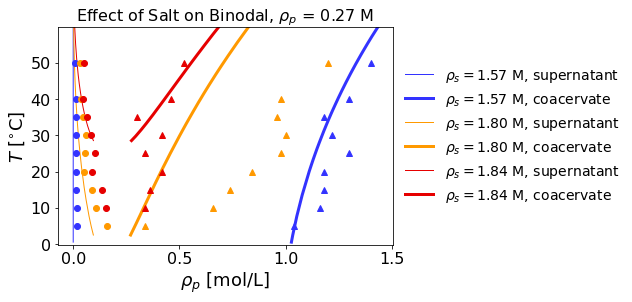

In [9]:
from importlib import reload
reload(plot)

# VARY SALT CONCENTRATION (ALI ET AL. 2019 DATA)
ch_var = 's' # varies salt
rho_s_plot = [1.75, 2, 2.05] #[1.57, 1.78, 1.82]
rho_p_plot = 0.3#0.27
T_range = [273, 333] # [K]

# plot parameters
lw=3 # line width for binodals
colors = ['#3333ff', '#ff9900', '#e60000']


plot.validate_fit(data_pred, df_exp, ch_var, rho_s_plot, rho_p_plot, colors, 
             beads_2_M_opt, sigma=sigma_opt, T_range=T_range, lw=lw, conv_vals=conv_vals)

Now we plot the results from Ma et al. (2021)

C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.



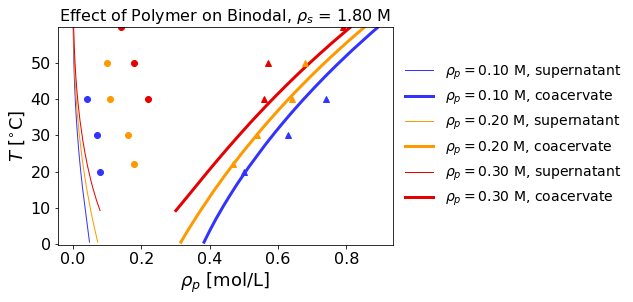

In [10]:
ch_var = 'p' # varies polyelectrolyte
rho_s_plot = 1.8
rho_p_plot = [0.1, 0.2, 0.3]

plot.validate_fit(data_pred, df_exp, ch_var, rho_p_plot, rho_s_plot, colors, 
             beads_2_M_opt, sigma=sigma_opt, T_range=T_range, lw=lw, conv_vals=False)